# Case Study

## Goals

Our goals for this case study include the following:
   * Visualize preliminary data using correlation matrices, graphs to determine if hypothesis is vaild
   * Create a combination of gold and copper that can be used as a feature to predict long dated treasuries
   * Run OLS to test predicatability
   * Run stationarity and cointegration tests
   * Create, backtest, visualize, and assess our pairs trading strategy

In [327]:
# import packages and libraries

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import hvplot.pandas
import holoviews as hv
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots


First we will import and clean our data.

In [328]:
# import and clean raw data

from pathlib import Path

data_path = Path('../Resources/Assignment Data (Quant Strategist - Los Angelesl).csv')
raw_data = pd.read_csv(data_path, header=3, index_col='Date', encoding='cp1252')
raw_data = raw_data.loc[:, ~raw_data.columns.str.contains('^Unnamed')]
raw_data.dropna(inplace=True)
raw_data.index = pd.to_datetime(raw_data.index)

# remove commas from column headers

colList = []

for col in raw_data.columns:
    colList.append(col.replace(',', ''))
    
raw_data.columns = colList
    

Create a Gold/Copper Index and a Treasury Index to allow for further analysis.

In [329]:
# Add Gold/Copper Index to dataframe

data = raw_data
data['Gold/Copper Index'] = data['Gold Price Index'] / data['Copper Price Index']

# Add duration balanced 10 & 30 year index to dataframe
data['10 + 30 Year Excess Return Index'] = data['United States 10 Year Treasury Note Constant Maturity Excess Return Index (Excess of Cash)'] + data['United States 30 Year Treasury Bond Constant Maturity Excess Return Index (Excess of Cash)'] * (data['United States 10 year Treasury Modified Duration'] / data['United States 30 year Treasury Modified Duration'])

# remove commas from column headers



data.head()

,Gold Price Index,Copper Price Index,Gold Excess Return Index (Excess of Cash),Copper Excess Return Index (Excess of Cash),United States 10 Year Treasury Note Constant Maturity Total Return Index,United States 30 Year Treasury Bond Constant Maturity Total Return Index,Treasury Repo Rate,United States 10 Year Treasury Note Constant Maturity Excess Return Index (Excess of Cash),United States 30 Year Treasury Bond Constant Maturity Excess Return Index (Excess of Cash),United States 10 year Treasury Mid Yield,United States 30 year Treasury Mid Yield,United States 10 year Treasury Modified Duration,United States 30 year Treasury Modified Duration,Gold/Copper Index,10 + 30 Year Excess Return Index
Date,,,,,,,,,,,,,,,
2000-06-09,290.78,80.37,44.94,111.00,261.12,283.57,6.64,100.00,100.00,6.12,5.89,7.01,13.78,3.618017,150.870827
2000-06-12,293.22,80.11,45.35,110.57,261.86,283.99,6.65,100.26,100.12,6.08,5.88,7.01,13.78,3.660217,151.191872
2000-06-13,291.98,80.86,45.20,111.54,261.48,281.52,6.65,100.09,99.23,6.10,5.94,7.00,13.71,3.610932,150.754478
2000-06-14,297.83,81.72,46.14,112.63,262.54,282.70,6.58,100.47,99.62,6.05,5.91,7.01,13.74,3.644518,151.295051
2000-06-15,295.69,82.54,45.81,113.77,262.62,282.20,6.65,100.47,99.42,6.05,5.93,7.01,13.73,3.582384,151.229956


In [330]:
# Create a dataframe of daily returns and a dataframe of log returns, where applicable

returns = data.copy()
log_returns = data.copy()

for col in returns.columns:
    if returns.columns.get_loc(col) < 6 or returns.columns.get_loc(col) == 7 or returns.columns.get_loc(col) == 8 or returns.columns.get_loc(col) == 13:
        returns[col] = returns[col].pct_change()
        
returns.dropna(axis=0, inplace=True)

for col in returns.columns:
    if returns.columns.get_loc(col) < 6 or returns.columns.get_loc(col) == 7 or returns.columns.get_loc(col) == 8 or returns.columns.get_loc(col) == 13:
        log_returns[col] = np.log(1+returns[col])

log_returns.dropna(inplace=True)

returns.head()

,Gold Price Index,Copper Price Index,Gold Excess Return Index (Excess of Cash),Copper Excess Return Index (Excess of Cash),United States 10 Year Treasury Note Constant Maturity Total Return Index,United States 30 Year Treasury Bond Constant Maturity Total Return Index,Treasury Repo Rate,United States 10 Year Treasury Note Constant Maturity Excess Return Index (Excess of Cash),United States 30 Year Treasury Bond Constant Maturity Excess Return Index (Excess of Cash),United States 10 year Treasury Mid Yield,United States 30 year Treasury Mid Yield,United States 10 year Treasury Modified Duration,United States 30 year Treasury Modified Duration,Gold/Copper Index,10 + 30 Year Excess Return Index
Date,,,,,,,,,,,,,,,
2000-06-12,0.008391,-0.003235,0.009123,-0.003874,0.002834,0.001481,6.65,0.002600,0.001200,6.08,5.88,7.01,13.78,0.011664,151.191872
2000-06-13,-0.004229,0.009362,-0.003308,0.008773,-0.001451,-0.008697,6.65,-0.001696,-0.008889,6.10,5.94,7.00,13.71,-0.013465,150.754478
2000-06-14,0.020036,0.010636,0.020796,0.009772,0.004054,0.004192,6.58,0.003797,0.003930,6.05,5.91,7.01,13.74,0.009301,151.295051
2000-06-15,-0.007185,0.010034,-0.007152,0.010122,0.000305,-0.001769,6.65,0.000000,-0.002008,6.05,5.93,7.01,13.73,-0.017049,151.229956
2000-06-16,-0.003652,0.007027,-0.003711,0.007120,0.005559,0.007477,6.65,0.005275,0.007141,5.98,5.88,7.01,13.77,-0.010605,151.973951


We visualize the hypothesized relationship between treasury rates and the Gold/Copper Index we created. Below we can see that indeed there appears to be a negative correlation between rates and our gold/copper ratio.

In [331]:
# visualize yields vs. gold/copper index to confirm hypothesis of inverse relationship

data.hvplot(x='Date', y=['Gold/Copper Index', 'United States 10 year Treasury Mid Yield', 'United States 30 year Treasury Mid Yield'])

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

Again, we can see this relationship clearly in the correlation matrix heatmap below. We can also note that a lot of our data appreas to be heavily correlated. Due to this we will have to choose our regression features carefully to avoid multicollinearity issues.

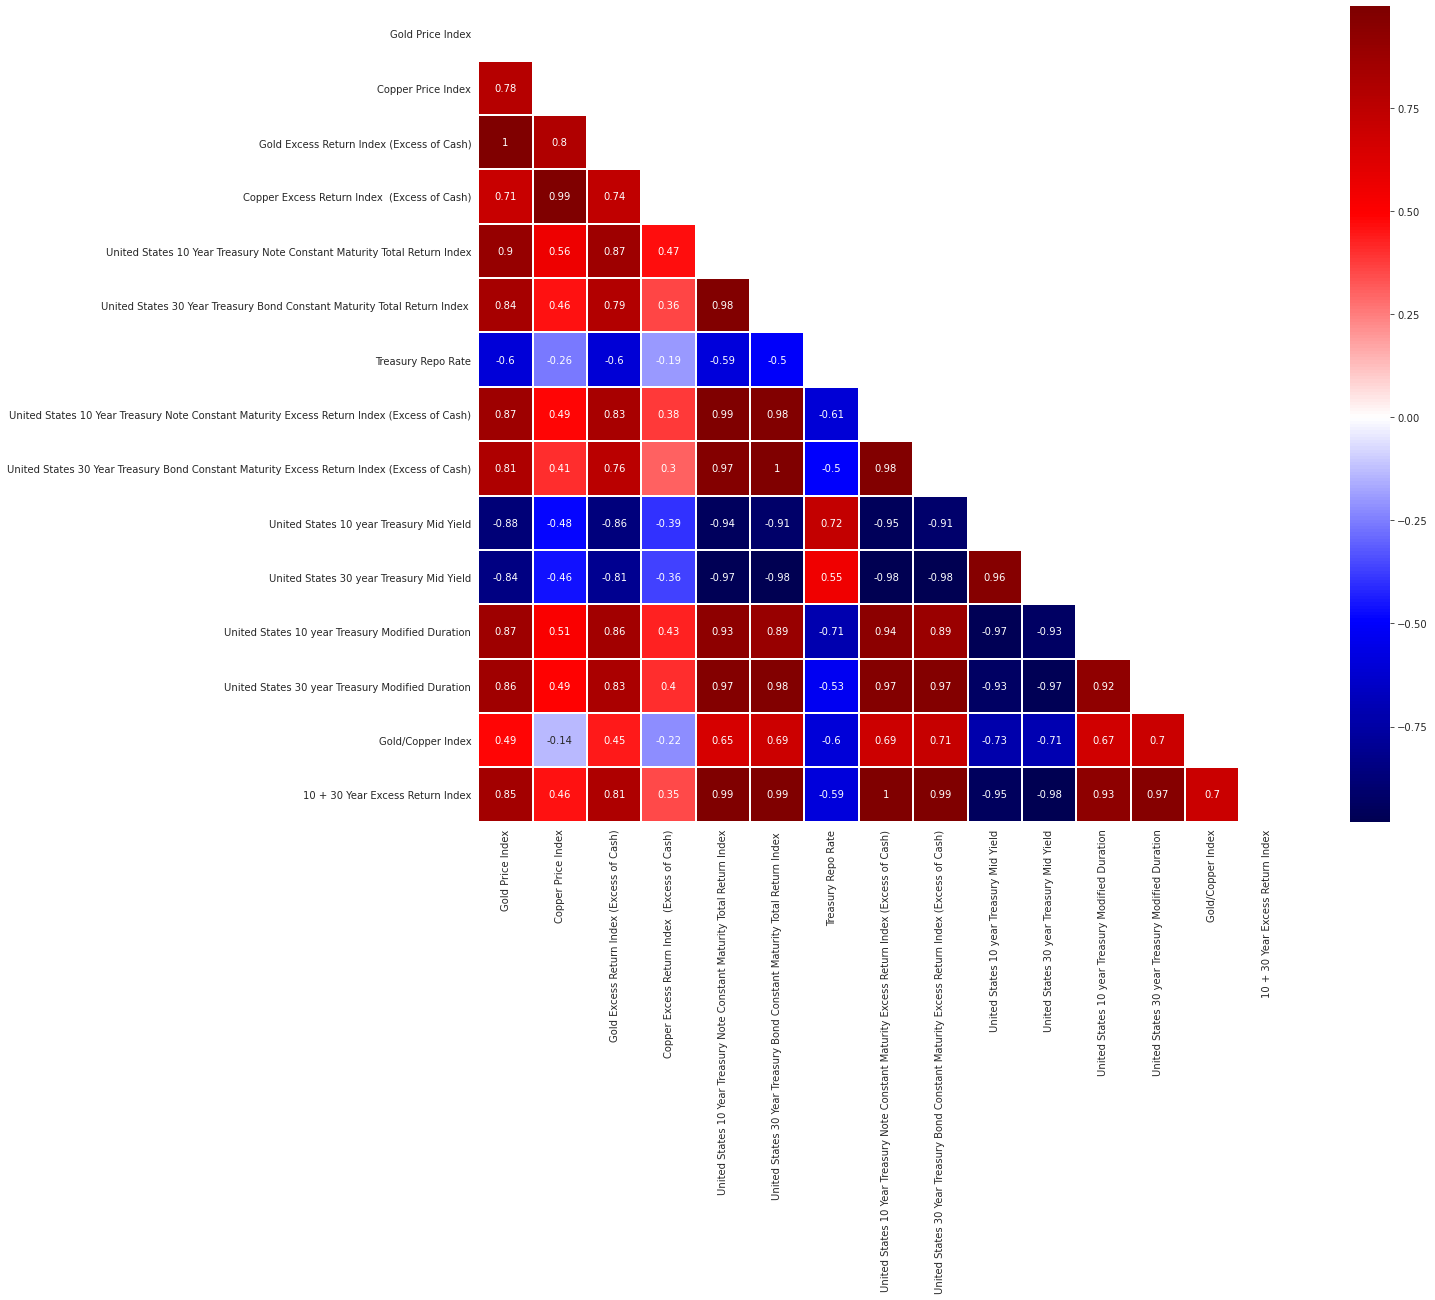

In [332]:
# visualize correlation matrix

corrM = data.corr()

mask = np.zeros_like(corrM)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corrM, mask=mask, center=0, annot=True, square=True, linewidths=1, cmap="seismic")

Below we visualize these correlations in a different manner. Here we can see that the 10 and 30 year treasury-derived series (yields, excess returns, modified duration) all have similiar correlation coefficients.

In [333]:
# Alternatively, we can view just the Gold/Copper Index correlations

corrM['Gold/Copper Index'].iloc[:-1].hvplot.barh() + corrM['Gold/Copper Index'].iloc[:-1].hvplot.table(width=200)

:Layout
   .Bars.Gold_over_Copper_Index :Bars   [index]   (Gold/Copper Index)
   .Table.I                     :Table   [Gold/Copper Index]

Using the visualizations above, we decide to create a dataframe of regression features including just the excess returns indices of copper and gold. Many regressions were run and the added value of including Treasury Repo Rate was negligable. Additionally, including treasury-linked time series as features would insure spurious regression so these were excluded as well.

In [334]:
# create X (feature dataframe) using appropriate features
# attempt to eliminate colinear features to prevent spurious regression

lr_features = data.drop(labels={'Gold Price Index', 'Copper Price Index',
       'United States 10 Year Treasury Note Constant Maturity Total Return Index',
       'United States 30 Year Treasury Bond Constant Maturity Total Return Index ',
       'United States 10 Year Treasury Note Constant Maturity Excess Return Index (Excess of Cash)',
       'United States 30 Year Treasury Bond Constant Maturity Excess Return Index (Excess of Cash)',
       'United States 10 year Treasury Mid Yield',
       'United States 30 year Treasury Mid Yield',
       'United States 10 year Treasury Modified Duration',
       'United States 30 year Treasury Modified Duration', 'Gold/Copper Index', 'Treasury Repo Rate', '10 + 30 Year Excess Return Index'}, axis=1)

lr_features.head()

,Gold Excess Return Index (Excess of Cash),Copper Excess Return Index (Excess of Cash)
Date,,
2000-06-09,44.94,111.00
2000-06-12,45.35,110.57
2000-06-13,45.20,111.54
2000-06-14,46.14,112.63
2000-06-15,45.81,113.77


Below we run our OLS multi-linear regression. We use a 60/40 training/test split and find an r-squared of .861. 60/40 was also chosen to allow inclusion of the Great Recession in attempt to make our model more robust.

In [335]:
# OLS

lr_model = LinearRegression()

X = lr_features.iloc[:3000]
y = data['10 + 30 Year Excess Return Index'].iloc[:3000].to_frame()
lr_model.fit(X, y)
test = X

predictions = lr_model.predict(X)
predictions

# Calculate r2_score (r-squared)
r2 = r2_score(y, predictions)

# Calculate mean squared error 
mse = mean_squared_error(y, predictions)

# Using mean squared error above, calculate root-mean-squared error (RMSE)
rmse = np.sqrt(mse)

# Print the r2, mser, rmse, and standard deviation
print(f"R-squared (R2 ): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Standard Deviation: {np.std(y)}")

# with statsmodels print detailed reults

X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

R-squared (R2 ): 0.8226141406133471
Mean Squared Error (MSE): 116.1702817441924
Root Mean Squared Error (RMSE): 10.778231846837977
Standard Deviation: 10 + 30 Year Excess Return Index    25.591045
dtype: float64
                                   OLS Regression Results                                   
Dep. Variable:     10 + 30 Year Excess Return Index   R-squared:                       0.823
Model:                                          OLS   Adj. R-squared:                  0.822
Method:                               Least Squares   F-statistic:                     6949.
Date:                              Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                                      18:18:32   Log-Likelihood:                -11389.
No. Observations:                              3000   AIC:                         2.278e+04
Df Residuals:                                  2997   BIC:                         2.280e+04
Df Model:                                   

Now that we have run our regression we can use the intercept and coefficients to create a 'Gold + Copper Weighted Index.'

In [336]:
# Plot our regression generated Gold/Copper weighted combination against our 10 + 30 Year Treasury Index

train = lr_features[:3000].copy()
train['Gold + Copper Excess Return Index'] = 152.477 + train['Gold Excess Return Index (Excess of Cash)'] * 0.6688 +  train['Copper Excess Return Index  (Excess of Cash)'] * -0.0517

train['10 + 30 Year Excess Return Index'] = data['10 + 30 Year Excess Return Index'].iloc[:3000]

train.hvplot(x='Date', y=['Gold + Copper Excess Return Index', '10 + 30 Year Excess Return Index'], grid=True)


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

We can then test for cointegration to check that our two series are indeed cointegrated and ideal candidates for pairs trading. 

In [337]:
# Test for cointegration

def cointegration(a, b):
  if ts.coint(a, b)[1] < 0.10:
    print('The series are cointegrated')
    print('p-value = ', ts.coint(a, b)[1])
  else:
    print('The series are NOT cointegrated')
    print('p-value = ', ts.coint(a, b)[1])

cointegration(train['10 + 30 Year Excess Return Index'], train['Gold + Copper Excess Return Index'])

The series are cointegrated
p-value =  0.06122027529845231


Below we plot the spread and ratio between the two. We can visualize lines at 0 and 1 on our spread and ratio plots, respecitively. We anctipate this lines being centered due to our regression.

In [338]:
# Calculate and plot the spread 

train['Spread'] = train['Gold + Copper Excess Return Index'] - train['10 + 30 Year Excess Return Index']
zero_line = hv.HLine(0)
zero_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)

plot = train.hvplot(x='Date', y=['Spread'], grid=True)
plot * zero_line

:Overlay
   .Curve.I :Curve   [Date]   (Spread)
   .HLine.I :HLine   [x,y]

In [339]:
# We can alo examine the ratio

train['Ratio'] = train['Gold + Copper Excess Return Index'] / train['10 + 30 Year Excess Return Index']

one_line = hv.HLine(1)
one_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)

ratio_plot = train.hvplot(x='Date', y=['Ratio'], grid=True)
ratio_plot * one_line



:Overlay
   .Curve.I :Curve   [Date]   (Ratio)
   .HLine.I :HLine   [x,y]

In [340]:
# Check for stationarity in the spread and ratio

def stationarity(a, cutoff = .05):
    a = np.ravel(a)
    if ts.adfuller(a)[1] < cutoff:
        print('The series is stationary')
        print('p-value = ', ts.adfuller(a)[1])
    else:
        print('The series is NOT stationary')
        print('p-value = ', ts.adfuller(a)[1])

stationarity(train['Spread'])
stationarity(train['Ratio'])

The series is stationary
p-value =  0.01692076914185927
The series is stationary
p-value =  0.02040752446472558


Below we plot the z-scores of our ratio, in preparation for creating our pairs trading/mean reverting trading model based off of standard devations.

In [341]:
# Plot z-scores of the ratio

def zscore(series):
    return (series - series.mean()) / np.std(series)

train['Z-Score'] = zscore(train['Ratio'])

zscore_plot = train.hvplot(x='Date', y=['Z-Score'])
z_zero_line = hv.HLine(0)
z_zero_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)
z_plus_one = hv.HLine(1)
z_plus_one.opts(color = 'red', line_dash = 'dashed', line_width=2.0)
z_minus_one = hv.HLine(-1)
z_minus_one.opts(color = 'green', line_dash = 'dashed', line_width=2.0)

zscore_plot * z_zero_line * z_plus_one * z_minus_one

:Overlay
   .Curve.I   :Curve   [Date]   (Z-Score)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

In the graph below, we are visualizing our ratio data and overlaying moving averages in order to generate appropriate mean-reverting signals.

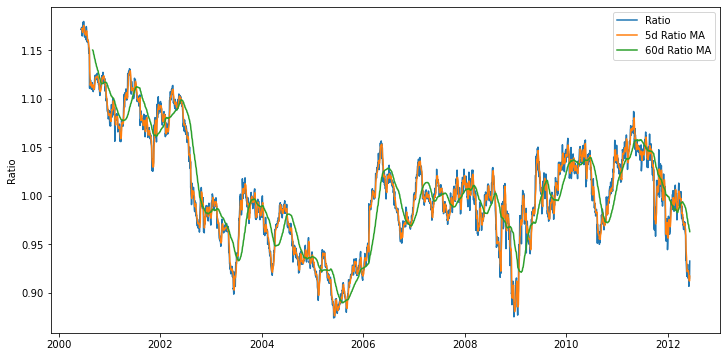

In [342]:
# Feature Engineering for training

feature_train = train['Ratio']

ratios_mavg5 = feature_train.rolling(window=5, center=False).mean()
ratios_mavg60 = feature_train.rolling(window=60, center=False).mean()
std_60 = feature_train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(feature_train.index, feature_train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
    
plt.show()


Using these moving averages we can create a rolling ratio z-score. Analyzing the graph below it looks like moves below and above -1 and 1, respecively, may genearte positive trading signals.

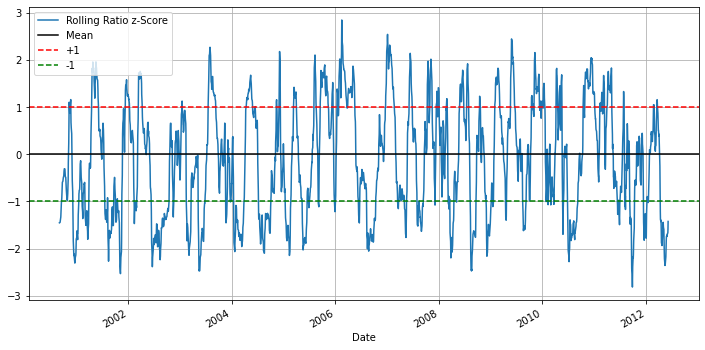

In [343]:
plt.figure(figsize=(12,6))
zscore_60_5.plot(grid=True)
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

In the graph below, we plot our ratio overlayed iwth our buy and sell signals to visualize our trading algorithm.

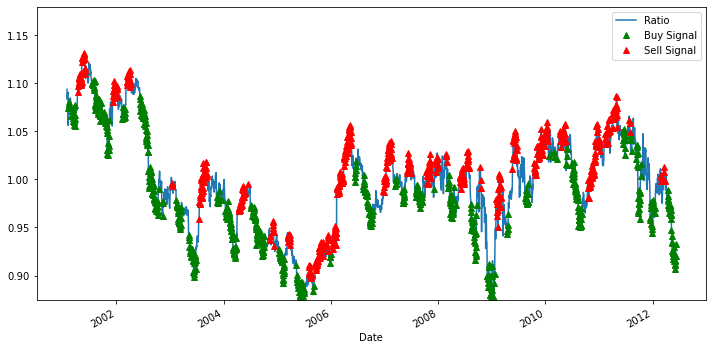

In [344]:
plt.figure(figsize=(12,6))

feature_train[160:].plot()
buy = feature_train.copy()
sell = feature_train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, train['Ratio'].min(), train['Ratio'].max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

Again, the graph below is just another way to visualize our trading algorithm. Here we are looking at the simulanteous buy and sell signals that are generated in the underlying indices. One thing to keep in mind is that because our regression calcualted a positve beta coefficient for gold and a negative coefficient for copper, when we long the spread, we are actually buying gold and selling copper, while selling the 10 year and 30 year treasuries, and vice versa.

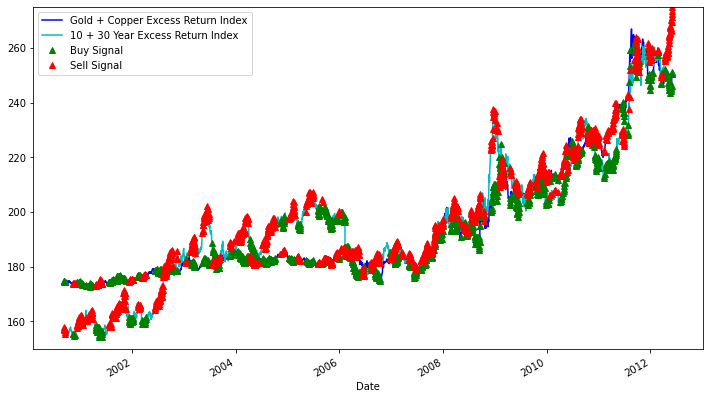

In [345]:
plt.figure(figsize=(12,7))
S1 = train['Gold + Copper Excess Return Index'].iloc[:3000]
S2 = train['10 + 30 Year Excess Return Index'].iloc[:3000]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy x and sell y
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell x and buy y
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.legend(['Gold + Copper Excess Return Index', '10 + 30 Year Excess Return Index', 'Buy Signal', 'Sell Signal'])
plt.show()

Below we create and run a simple trading function to capture our profit/loss. We anticipate this model doing very well because we are running this over our regressed, in-sample data.

In [346]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    
    # intiliazae trading results dataframe
    trading_results = pd.DataFrame(index=S1.index, columns=['equity', 'ratios', 'countS1', 'countS2'])
    
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            trading_results['equity'][i] = money
            trading_results['ratios'][i] = ratios[i]
            trading_results['countS1'][i] = countS1
            trading_results['countS2'][i] = countS2
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            trading_results['equity'][i] = money
            trading_results['ratios'][i] = ratios[i]
            trading_results['countS1'][i] = countS1
            trading_results['countS2'][i] = countS2
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            trading_results['equity'][i] = money
            trading_results['ratios'][i] = ratios[i]
            trading_results['countS1'][i] = countS1
            trading_results['countS2'][i] = countS2
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money, trading_results

Below we visualize our equity curve and display our final equity. It appears drawdowns are limited and the curve is relatively linear.

In [347]:
# Run the trading similuation and visualize the equity curve

train_total_equity, train_trading_results = trade(train['Gold + Copper Excess Return Index'], train['10 + 30 Year Excess Return Index'], 60, 5)
train_trading_results_plot = train_trading_results.dropna().hvplot(x='Date', y=['equity'])
train_trading_results_plot

:Curve   [Date]   (equity)

In [348]:
# Print total equity from the simulation above

print(train_total_equity)

4071.0779560821034


Now we will look to repeat the same process for our test data. Recall that our test data is the most recent 40% of data from our original data. We can already see, based on the graph below, that our gold + copper index isn't as neatly intertwined with our treasury index.

In [349]:
# Now we look to test our system outside of training data
# Plot our regression generated Gold/Copper weighted combination against our 10 + 30 Year Treasury Index

test = lr_features[3001:].copy()
test['Gold + Copper Excess Return Index'] = 152.4777 + test['Gold Excess Return Index (Excess of Cash)'] * 0.6688 +  test['Copper Excess Return Index  (Excess of Cash)'] * -0.0517

test['10 + 30 Year Excess Return Index'] = data['10 + 30 Year Excess Return Index']

test.hvplot(x='Date', y=['Gold + Copper Excess Return Index', '10 + 30 Year Excess Return Index'], grid=True)



:NdOverlay   [Variable]
   :Curve   [Date]   (value)

As we did before we plot the spread and the ratio. We can see that our spread and ratio don't center around 0 and 1, but we hope that our model can capture the mean-reverting nature of these spreads.

In [350]:
# Calculate and plot the spread 

test['Spread'] = test['Gold + Copper Excess Return Index'] - test['10 + 30 Year Excess Return Index']
mean_line = hv.HLine(np.mean(test['Spread']))
mean_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)

test_plot = test.hvplot(x='Date', y=['Spread'], grid=True)
test_plot * mean_line

:Overlay
   .Curve.I :Curve   [Date]   (Spread)
   .HLine.I :HLine   [x,y]

In [351]:
# Plot ratio of test data

test['Ratio'] = test['Gold + Copper Excess Return Index'] / test['10 + 30 Year Excess Return Index']

ratio_mean_line = hv.HLine(np.mean(test['Ratio']))
ratio_mean_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)

ratio_plot = test.hvplot(x='Date', y=['Ratio'], grid=True)
ratio_plot * ratio_mean_line


:Overlay
   .Curve.I :Curve   [Date]   (Ratio)
   .HLine.I :HLine   [x,y]

Like in the train data, we plot the z-score and visualize our feature engineering indicators, making sure to keep the same parameters that we used in our training model.

In [352]:
# Plot z-scores of the ratio

test['Z-Score'] = zscore(test['Ratio'])

zscore_plot = test.hvplot(x='Date', y=['Z-Score'])
z_zero_line = hv.HLine(0)
z_zero_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)
z_plus_one = hv.HLine(1)
z_plus_one.opts(color = 'red', line_dash = 'dashed', line_width=2.0)
z_minus_one = hv.HLine(-1)
z_minus_one.opts(color = 'green', line_dash = 'dashed', line_width=2.0)

zscore_plot * z_zero_line * z_plus_one * z_minus_one

:Overlay
   .Curve.I   :Curve   [Date]   (Z-Score)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

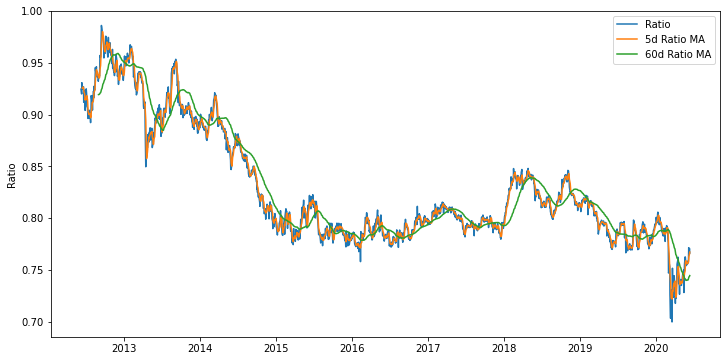

In [353]:
feature_test = test['Ratio']


ratios_mavg5 = feature_test.rolling(window=5, center=False).mean()
ratios_mavg60 = feature_test.rolling(window=60, center=False).mean()
std_60 = feature_test.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(feature_test.index, feature_test.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

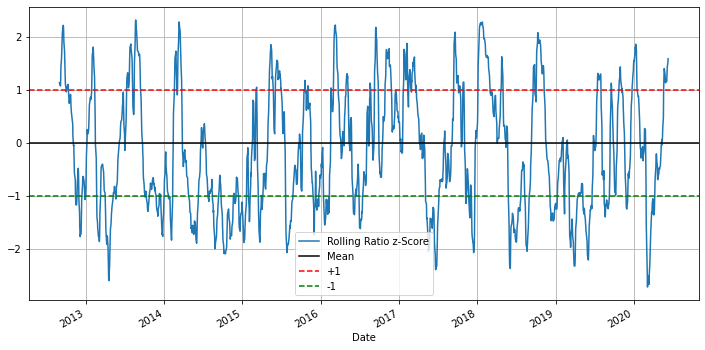

In [354]:
plt.figure(figsize=(12,6))
zscore_60_5.plot(grid=True)
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

The graphs below show us when we are initiating trades.

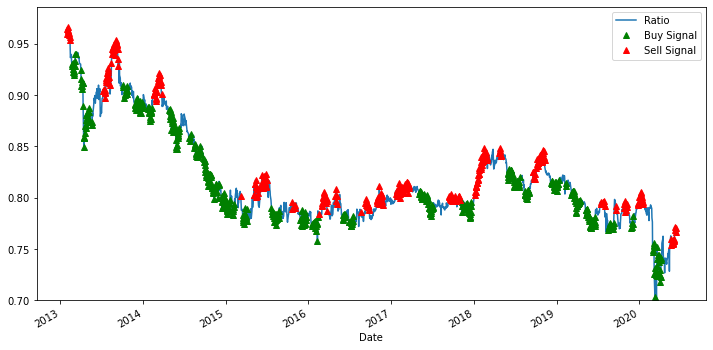

In [355]:
plt.figure(figsize=(12,6))

feature_test[160:].plot()
buy = feature_test.copy()
sell = feature_test.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, test['Ratio'].min(), test['Ratio'].max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

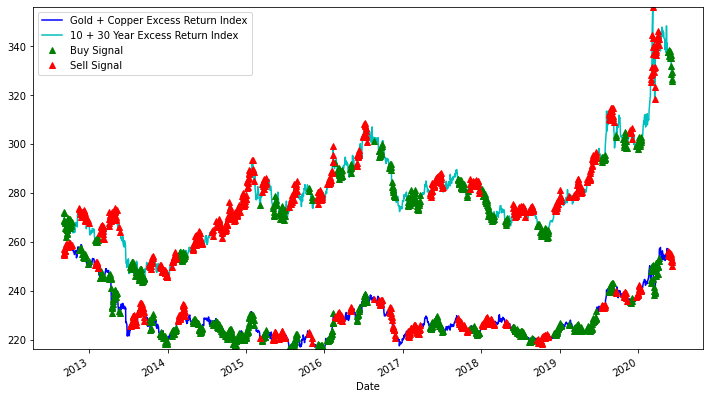

In [356]:
plt.figure(figsize=(12,7))
S1 = test['Gold + Copper Excess Return Index']
S2 = test['10 + 30 Year Excess Return Index']

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy x and sell y
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell x and buy y
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.legend(['Gold + Copper Excess Return Index', '10 + 30 Year Excess Return Index', 'Buy Signal', 'Sell Signal'])
plt.show()

Below we visualize our equity curve for our test simulation. As we can ascertain the equity curve is more volatile and we experience a large drawdown of about -910 in the beginning of 2015. Looking at our feature engineering visualization above we can see that our our ratio does indeed divert in 2014 and after exiting our positions on a reversion back to a abs(.75) z-score, we encounter this large drawdown. However our results are still strong and we can see a upward sloping equity curve with a final equity of ~1392. 

In [357]:
# Run the test data through the trading similation function

test_total_equity, train_trading_results = trade(test['Gold + Copper Excess Return Index'], test['10 + 30 Year Excess Return Index'], 60, 5)
test_trading_results_plot = train_trading_results.dropna().hvplot(x='Date', y=['equity'])
test_trading_results_plot

:Curve   [Date]   (equity)

In [358]:
# Print total equity from the simulation above

print(test_total_equity)

1392.19678608281


## Final Thoughts and Further Analysis

The model appears to be fairly robust, especially given such a large testing dataset. However, I think further improvement is warranted. The strategy often initiates the same positions day after day given that standard deviations can persist outside of +1 and -1 for large periods of time. An excess return analysis employing Sortino or Sharpe ratios could be warranted to better understand the risk-adjusted returns. 

Additionally, other next steps would include creating more dynamic functions to loop through various engineering features, such as different MA combinations, different z-score signal levels, etc. Another way to enhance this model is to periodically update regressions throughout the dataset (i.e. testing and training on the first 5% of data, updating the regressed values, and repeating). However, this may lead to overfitting. Also, with fundamental-based indicator like Gold/Copper this may prove disadvantageous as it may not include enough of the economic cycle for the model to be robust.

I would also like to explore using Long Short-Term Memory Networks (LSTM) and Principal Component Analysis as an alternative to OLS and compare and contrast the results.
